In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns
from calendar import month_name

In [21]:
# Read metadata
metadata = pd.read_excel('data/metadata_10%_79pos_2010-01-01.xlsx') 
metadata = metadata.set_index(['Pos Hujan ID'])
metadata

,Nama Stasiun,Balai,Provinsi,Kabupaten,Lintang,Bujur,Elevasi,ZOM
Pos Hujan ID,,,,,,,,
34010101a,BPP Temon,Region II,DI Yogyakarta,Kab. Kulon Progo,-7.89000,110.08000,0,273
34010201a,Beji,Region II,DI Yogyakarta,Kab. Kulon Progo,-7.87300,110.16200,0,273
34010202a,BPP Kulwaru,Region II,DI Yogyakarta,Kab. Kulon Progo,-7.89000,110.11700,0,273
34010301a,BPP Panjatan,Region II,DI Yogyakarta,Kab. Kulon Progo,-7.92308,110.15800,0,273
34010401a,PSDA Brosot,Region II,DI Yogyakarta,Kab. Kulon Progo,-7.95000,110.22400,0,273
...,...,...,...,...,...,...,...,...
34041504a,Tunggularum,Region II,DI Yogyakarta,Kab. Sleman,-7.59981,110.39375,748,269
34041601a,Pakem,Region II,DI Yogyakarta,Kab. Sleman,-7.67308,110.42014,0,269
34041701a,Bronggang,Region II,DI Yogyakarta,Kab. Sleman,-7.66086,110.44419,0,269


In [22]:
# Read drought samples
drought_samples = pd.read_excel('data/dataset_kekeringan_2018-2024.xlsx') 
# drought_samples = drought_samples.set_index(['id'])
drought_samples

,id,kecamatan,kabupaten,period_start,period_end,luas_kumulatif,musim_tanam,zom
0,1,Ponjong,Kab. Gunungkidul,2018-05-16,2018-06-15,17.0,April-September,274
1,2,Rongkop,Kab. Gunungkidul,2018-05-16,2018-06-15,8.0,April-September,271
2,3,Playen,Kab. Gunungkidul,2018-05-16,2018-06-15,15.0,April-September,271
3,4,Wonosari,Kab. Gunungkidul,2018-05-16,2018-06-15,38.0,April-September,271
4,5,Karangmojo,Kab. Gunungkidul,2018-05-16,2018-06-15,12.0,April-September,271
...,...,...,...,...,...,...,...,...
105,106,Saptosari,Kab. Gunungkidul,2024-06-16,2024-06-30,3.0,April-September,273
106,107,Playen,Kab. Gunungkidul,2024-06-16,2024-06-30,9.0,April-September,272
107,108,Karangmojo,Kab. Gunungkidul,2024-06-16,2024-08-31,162.0,April-September,272
108,109,Dlingo,Kab. Bantul,2024-07-01,2024-08-15,60.0,April-September,272


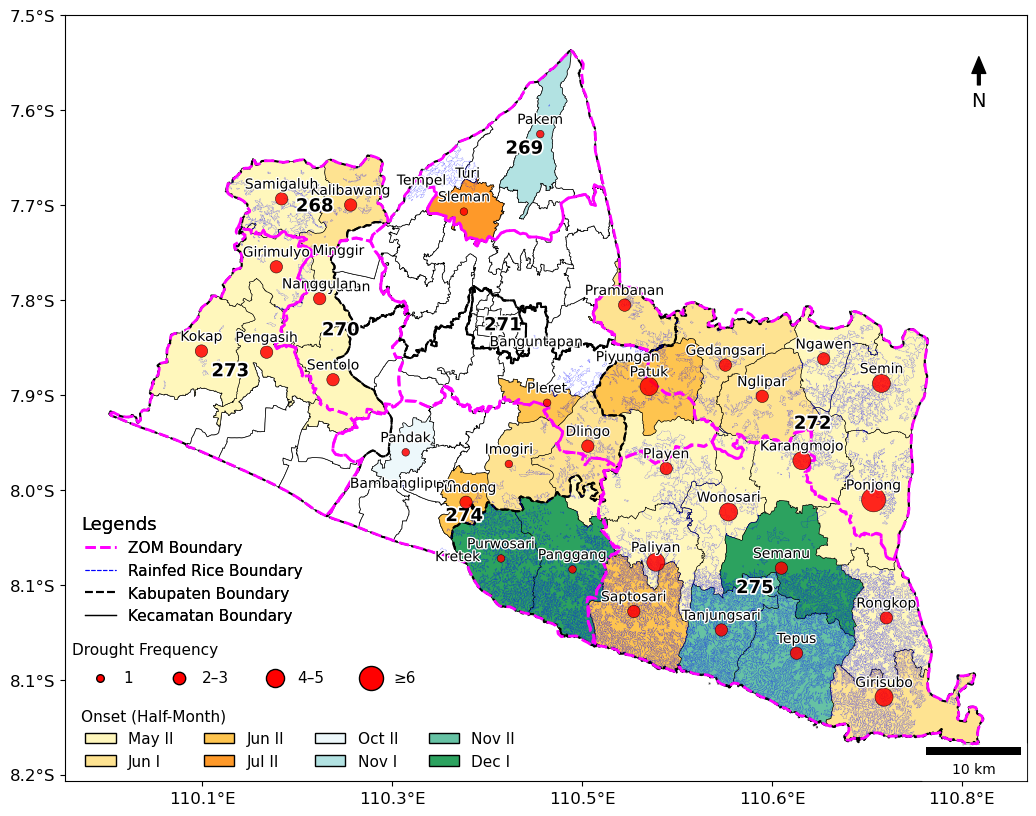

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
import matplotlib.ticker as mticker
from pyproj import Transformer
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

# Load administrative boundaries and thematic layers
shp_kecamatan = gpd.read_file("data/shp/kecamatan_diy.shp")
shp_kabupaten = gpd.read_file("data/shp/kabupaten_diy.shp")
shp_provinsi = gpd.read_file("data/shp/diy-jateng.shp")
shp_zom = gpd.read_file("ZOM9120_DIY.shp")
shp_sawah = gpd.read_file("data/shp/sawah_tadah_hujan_kecamatan.shp")

# prepare drought onset category and frequency
drought_samples['period_start'] = pd.to_datetime(drought_samples['period_start'])

def halfmonth_label(dt):
    if pd.isna(dt): return pd.NA
    half = "I" if dt.day <= 15 else "II"
    return f"{dt.strftime('%b')} {half}"

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
half_labels = [f"{m} {half}" for m in months for half in ["I", "II"]]


drought_samples['onset_half'] = drought_samples['period_start'].apply(halfmonth_label)
drought_samples['onset_half'] = pd.Categorical(drought_samples['onset_half'],
                                               categories=half_labels,
                                               ordered=True)

freq = drought_samples.groupby(['kecamatan','kabupaten']).agg(
    kejadian=('onset_half', 'count'),
    onset_mode=('onset_half', lambda x: x.mode().iat[0] if len(x.dropna()) > 0 else pd.NA)
).reset_index()

# filter only rainfed rice area shapefile
sawah_kec_list = shp_sawah['WADMKC'].unique().tolist()
freq = freq[freq['kecamatan'].isin(sawah_kec_list)].copy()

# reproject shapefiles to UTM Zone 49S
target_crs = "EPSG:32749"
shp_kecamatan = shp_kecamatan.to_crs(target_crs)
shp_kabupaten = shp_kabupaten.to_crs(target_crs)
shp_provinsi = shp_provinsi.to_crs(target_crs)
shp_sawah = shp_sawah.to_crs(target_crs)
shp_zom = shp_zom.to_crs(target_crs)

gdf = shp_kecamatan.merge(freq, left_on='WADMKC', right_on='kecamatan', how='left')
gdf['kejadian'] = gdf['kejadian'].fillna(0).astype(int)
gdf['onset_mode'] = pd.Categorical(gdf['onset_mode'], categories=half_labels, ordered=True)

# discrete colors for onset
present = gdf['onset_mode'].dropna().unique().tolist()
cats_present = [c for c in half_labels if c in present]   # ensure calendar order

N = len(cats_present)

from matplotlib.colors import LinearSegmentedColormap
# Define seasonal color maps

dry_months = ["Apr", "May", "Jun", "Jul", "Aug", "Sep"]
wet_months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]

# High-quality sequential palettes for publication
dry_colors = ["#fff7bc", "#fee391", "#fec44f", "#fe9929", "#ec7014", "#cc4c02"]  # light → dark orange/brown
wet_colors = ["#edf8fb", "#b2e2e2", "#66c2a4", "#2ca25f", "#1b9e77", "#0c7c59"]  # light → dark teal/blue

def assign_color_to_category(cat):
    """Assign color based on season (dry/wet) and order within its season."""
    if pd.isna(cat): 
        return None

    month, half = cat.split()  # e.g., "Jun I" → ("Jun","I")
    
    # DRY season (Apr–Sep)
    if month in dry_months:
        dry_cats = [c for c in cats_present if c.split()[0] in dry_months]
        idx = dry_cats.index(cat)
        return dry_colors[idx % len(dry_colors)]

    # WET season (Oct–Mar)
    else:
        wet_cats = [c for c in cats_present if c.split()[0] in wet_months]
        idx = wet_cats.index(cat)
        return wet_colors[idx % len(wet_colors)]

# Build the full color map dictionary
color_map = {cat: assign_color_to_category(cat) for cat in cats_present}

# Apply colors
gdf['onset_color'] = gdf['onset_mode'].map(color_map)

# cmap = plt.cm.get_cmap("copper", N)
# color_map = {cats_present[i]: cmap(i) for i in range(N)}

# gdf['onset_color'] = gdf['onset_mode'].map(color_map)

# When building the legend, list categories in calendar order but only include those present
cats_present_ordered = [
    c for c in half_labels
    if gdf['onset_mode'].astype(str).eq(c).any()
]


# figure setup
fig, ax = plt.subplots(figsize=(11.69, 8.27))
ax.set_aspect("equal")

# base map
gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
gdf[gdf['onset_mode'].notna()].plot(
    ax=ax,
    color=gdf.loc[gdf['onset_mode'].notna(), 'onset_color'],
    edgecolor='black',
    linewidth=0.4,
)

# sawah overlay
shp_sawah.boundary.plot(ax=ax, color='blue', linewidth=0.2, linestyle="--", alpha=0.8, zorder=7)

# kabupaten outline
shp_kabupaten.boundary.plot(ax=ax, color='black', linestyle="--", linewidth=1.5, zorder=3)

# zom outline
shp_zom.boundary.plot(ax=ax, color='#ff00ff', linestyle="--", linewidth=2, zorder=8)

# Determine centroid for each ZOM polygon
shp_zom["centroid"] = shp_zom.geometry.representative_point()

# Adjust this column name if your shapefile uses a different name
zom_col = "ZOM"   # change to the correct field name if needed

# Plot label for each ZOM
for _, row in shp_zom.iterrows():
    cx, cy = row["centroid"].x, row["centroid"].y
    label = str(row[zom_col])

    txt = ax.text(
        cx, cy,
        label,
        fontsize=13,
        fontweight="bold",
        ha="center",
        va="center",
        color="black",
        zorder=10
    )

    # Add white stroke for readability
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2.5, foreground='white'),
        path_effects.Normal()
    ])

# provinsi outline
# xmin, xmax = ax.get_xlim()
# ymin, ymax = ax.get_ylim()
# shp_provinsi.plot(
#     ax=ax,
#     color='whitesmoke',
#     edgecolor='grey',
#     linewidth=1,
#     zorder=0 
# )
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# frequency symbols
gdf['rep_point'] = gdf.geometry.representative_point()
pts = gpd.GeoDataFrame(gdf[['kecamatan','kejadian']], geometry=gdf['rep_point'], crs=target_crs)

# Updated drought frequency classes
freq_bins = [0, 1, 3, 5, 100]     # 1 | 2–3 | 4–5 | >=6
freq_labels = ["1", "2–3", "4–5", "≥6"]

pts['freq_class'] = pd.cut(
    pts['kejadian'],
    bins=freq_bins,
    labels=freq_labels,
    include_lowest=True
)

sizes = {
    "1": 30,
    "2–3": 80,
    "4–5": 170,
    "≥6": 300
}

pts['size'] = pts['freq_class'].map(sizes)

# remove 0-frequency
pts = pts[pts['kejadian'] > 0].copy()

pts['size'] = pts['freq_class'].map(sizes)

pts.plot(
    ax=ax,
    markersize=pts['size'],
    color='red',
    edgecolor='black',
    alpha=0.85,
    linewidth=0.4,
    zorder=10
)

# label for each rainfed rice kecamatan
sawah_centroids = (
    shp_sawah
    .dissolve(by="WADMKC")          # merge multipolygons per kecamatan
    .copy()
)
sawah_centroids["centroid"] = sawah_centroids.geometry.representative_point()

label_offset = 1500  # adjust padding above circle

import matplotlib.patheffects as path_effects

for kec, row in sawah_centroids.iterrows():
    cx, cy = row["centroid"].x, row["centroid"].y

    # If kecamatan has drought frequency, push label upward above point marker
    if kec in pts["kecamatan"].tolist():
        # find representative point from pts
        pt_geom = pts.loc[pts["kecamatan"] == kec, "geometry"].iloc[0]
        cx, cy = pt_geom.x, pt_geom.y + label_offset

    txt = ax.text(
        cx, cy,
        kec,
        fontsize=10,
        ha="center",
        va="center",
        color="black",
        zorder=10,
        # bbox=dict(facecolor="white", alpha=0.55, edgecolor="none", pad=1),
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.8, foreground='white'),
        path_effects.Normal()
    ])

# legend onset categorys (discrete colors)
legend_elements = [
    Patch(facecolor=color_map[c], edgecolor='black', label=c)
    for c in cats_present_ordered
]

legend_onset = ax.legend(
    handles=legend_elements,
    title="Onset (Half-Month)",
    loc="lower left",
    bbox_to_anchor=(0.0, -0.01),
    ncol=4,
    fontsize=11,
    title_fontsize=11,
    frameon=False,
    borderpad=0.8,
)
legend_onset.get_title().set_position((-147, 0))
ax.add_artist(legend_onset)

# legend drought frequency (size symbols)
freq_handles = [
    plt.scatter([], [], s=sizes[label], color='red', edgecolor='black', label=label)
    for label in freq_labels
]

legend_frequency = ax.legend(
    handles=freq_handles,
    title="Drought Frequency",
    loc="lower left",
    fontsize=11,
    title_fontsize=11,
    frameon=False,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.5,
    bbox_to_anchor=(0.0, 0.1),
    ncols=4,
)
legend_frequency.get_title().set_position((-105, 0))
ax.add_artist(legend_frequency)

# legend boundary: sawah, kabupaten, kecamatan
boundary_handles = [
    Line2D([0], [0], color='#ff00ff', linewidth=2, linestyle='--', label='ZOM Boundary'),
    Line2D([0], [0], color='blue', linewidth=0.8, linestyle='--', label='Rainfed Rice Boundary'),
    Line2D([0], [0], color='black', linewidth=1.5, linestyle='--', label='Kabupaten Boundary'),
    Line2D([0], [0], color='black', linewidth=0.9, label='Kecamatan Boundary')
]

legend_boundary = ax.legend(
    handles=boundary_handles,
    title="Legends",
    loc="lower left",
    fontsize=11,
    title_fontsize=13,
    frameon=False,
    borderpad=0.8,
    handletextpad=0.8,
    bbox_to_anchor=(0.0, 0.18),
)
legend_boundary.get_title().set_position((-75, 0))
ax.add_artist(legend_boundary)


# north arrow
ax.annotate(
    "N",
    xy=(0.95, 0.95),
    xytext=(0.95, 0.88),
    arrowprops=dict(facecolor='black', width=2, headwidth=10, shrink=0.1),
    ha="center",
    fontsize=14,
    xycoords=ax.transAxes,
)

# scalebar
scalebar = ScaleBar(1, location='lower right', box_alpha=0.7, length_fraction=0.1, pad=0.3)
ax.add_artist(scalebar)

# geographic axes labels
transformer = Transformer.from_crs(target_crs, "EPSG:4326", always_xy=True)

def format_lon(x, pos):
    lon, _ = transformer.transform(x, ax.get_ylim()[0])
    return f"{lon:.1f}°E"

def format_lat(y, pos):
    _, lat = transformer.transform(ax.get_xlim()[0], y)
    return f"{abs(lat):.1f}°S"

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.title("Onset (Half-Month) & Drought Frequency on Rainfed Rice Areas", fontsize=13)
plt.tight_layout()
plt.show()


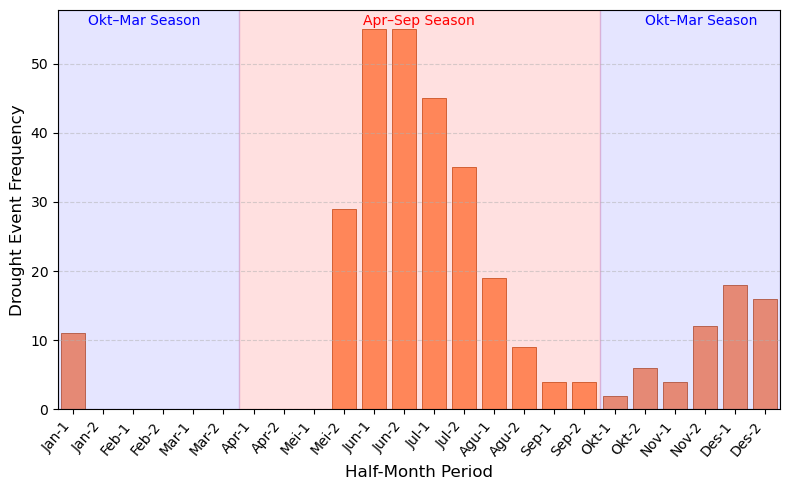

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
drought_samples["period_start"] = pd.to_datetime(drought_samples["period_start"])
drought_samples["period_end"] = pd.to_datetime(drought_samples["period_end"])

# Month names
month_names = ["Jan","Feb","Mar","Apr","Mei","Jun","Jul","Agu","Sep","Okt","Nov","Des"]

def get_halfmonth_label(dt):
    half = 1 if dt.day <= 15 else 2
    return f"{month_names[dt.month - 1]}-{half}"

# All half-month categories
all_halfmonths = [f"{month_names[m-1]}-{h}" for m in range(1, 13) for h in [1, 2]]

# Count frequency
halfmonth_freq = {hm: 0 for hm in all_halfmonths}

for _, row in drought_samples.iterrows():
    start = row["period_start"]
    end = row["period_end"]
    date_range = pd.date_range(start, end, freq="D")
    unique_hm = set(get_halfmonth_label(dt) for dt in date_range)
    for hm in unique_hm:
        halfmonth_freq[hm] += 1

freq_series = pd.Series(halfmonth_freq)

plt.figure(figsize=(8, 5))

# Plot bars
plt.bar(
    freq_series.index,
    freq_series.values,
    color="#ff9966",
    edgecolor="#cc6e3c",
    linewidth=0.7
)

# Remove the left and right empty space
plt.xlim(-0.5, len(freq_series) - 0.5)

# Determine indexes for seasonal ranges
hm_list = list(freq_series.index)

# Apr–Sep = Apr-1 (index 6) to Sep-2 (index 17)
apr_sep_start = hm_list.index("Apr-1")
apr_sep_end   = hm_list.index("Sep-2")

# Okt–Mar = Oct-1 (index 18) to Mar-2 (index 5)
okt_mar_start = hm_list.index("Okt-1")
okt_mar_end_1 = hm_list.index("Des-2")
okt_mar_end_2 = hm_list.index("Mar-2")

# Highlight Apr–Sep
plt.axvspan(apr_sep_start - 0.5, apr_sep_end + 0.5,
            color="red", alpha=0.12, label="Apr–Sep")

# Highlight Okt–Mar (two parts because it wraps to next year)
plt.axvspan(okt_mar_start - 0.5, okt_mar_end_1 + 0.5,
            color="blue", alpha=0.10)
plt.axvspan(-0.5, okt_mar_end_2 + 0.5,
            color="blue", alpha=0.10, label="Okt–Mar")

# Labels and formatting
# plt.title("Temporal Distribution of Drought Duration (Half-Month Basis)", fontsize=12)
plt.xlabel("Half-Month Period", fontsize=12)
plt.ylabel("Drought Event Frequency", fontsize=12)
plt.xticks(rotation=50, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add seasonal labels on top
plt.text((apr_sep_start + apr_sep_end)/2, max(freq_series)*1.01,
         "Apr–Sep Season", ha="center", color="red", fontsize=10)

plt.text((okt_mar_start + len(hm_list) + okt_mar_end_2)/2.25 % len(hm_list),
         max(freq_series)*1.01,
         "Okt–Mar Season", ha="center", color="blue", fontsize=10)
plt.text((okt_mar_start + len(hm_list) + okt_mar_end_2)/20 % len(hm_list),
         max(freq_series)*1.01,
         "Okt–Mar Season", ha="center", color="blue", fontsize=10)

plt.tight_layout()
plt.show()


Total kejadian pada sawah tadah hujan: 88


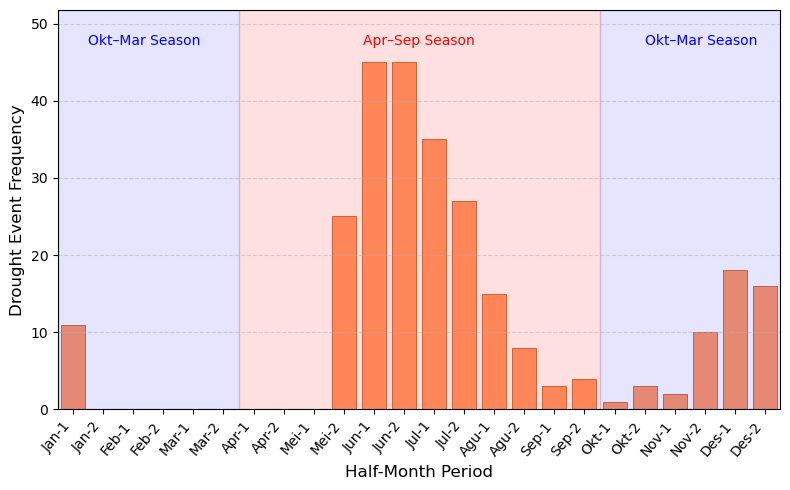

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter drought samples for rainfed rice areas
sawah_kec = shp_sawah["WADMKC"].str.strip().unique().tolist()

# Filter drought_samples
ds_rainfed = drought_samples[
    drought_samples["kecamatan"].isin(sawah_kec)
].copy()

print(f"Total kejadian pada sawah tadah hujan: {len(ds_rainfed)}")

# Ensure datetime format
ds_rainfed["period_start"] = pd.to_datetime(ds_rainfed["period_start"])
ds_rainfed["period_end"] = pd.to_datetime(ds_rainfed["period_end"])

# Month names
month_names = ["Jan","Feb","Mar","Apr","Mei","Jun","Jul","Agu","Sep","Okt","Nov","Des"]

def get_halfmonth_label(dt):
    half = 1 if dt.day <= 15 else 2
    return f"{month_names[dt.month - 1]}-{half}"

# All half-month categories
all_halfmonths = [f"{month_names[m-1]}-{h}" for m in range(1, 13) for h in [1, 2]]

# Initialize frequency counter
halfmonth_freq = {hm: 0 for hm in all_halfmonths}

# Count drought presence per half-month
for _, row in ds_rainfed.iterrows():
    start = row["period_start"]
    end = row["period_end"]

    # Range of days affected
    date_range = pd.date_range(start, end, freq="D")

    # Unique half-month categories for this event
    unique_hm = set(get_halfmonth_label(dt) for dt in date_range)

    for hm in unique_hm:
        halfmonth_freq[hm] += 1

# Convert to Series for plotting
freq_series = pd.Series(halfmonth_freq)

# Plotting
plt.figure(figsize=(8, 5))

plt.bar(
    freq_series.index,
    freq_series.values,
    color="#ff9966",
    edgecolor="#cc6e3c",
    linewidth=0.7
)

plt.xlim(-0.5, len(freq_series) - 0.5)

hm_list = list(freq_series.index)

# Seasonal ranges
apr_sep_start = hm_list.index("Apr-1")
apr_sep_end   = hm_list.index("Sep-2")

okt_mar_start = hm_list.index("Okt-1")
okt_mar_end_1 = hm_list.index("Des-2")
okt_mar_end_2 = hm_list.index("Mar-2")

# Highlight Apr–Sep
plt.axvspan(apr_sep_start - 0.5, apr_sep_end + 0.5,
            color="red", alpha=0.12, label="Apr–Sep")

# Highlight Okt–Mar (two segments)
plt.axvspan(okt_mar_start - 0.5, okt_mar_end_1 + 0.5,
            color="blue", alpha=0.10)
plt.axvspan(-0.5, okt_mar_end_2 + 0.5,
            color="blue", alpha=0.10, label="Okt–Mar")

# Labels
plt.xlabel("Half-Month Period", fontsize=12)
plt.ylabel("Drought Event Frequency", fontsize=12)
plt.xticks(rotation=50, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, max(freq_series)*1.15)

# Seasonal text
plt.text((apr_sep_start + apr_sep_end)/2, max(freq_series)*1.05,
         "Apr–Sep Season", ha="center", color="red", fontsize=10)

plt.text((okt_mar_start + len(hm_list) + okt_mar_end_2)/2.25 % len(hm_list),
         max(freq_series)*1.05,
         "Okt–Mar Season", ha="center", color="blue", fontsize=10)

plt.text((okt_mar_start + len(hm_list) + okt_mar_end_2)/20 % len(hm_list),
         max(freq_series)*1.05,
         "Okt–Mar Season", ha="center", color="blue", fontsize=10)

plt.tight_layout()
plt.show()


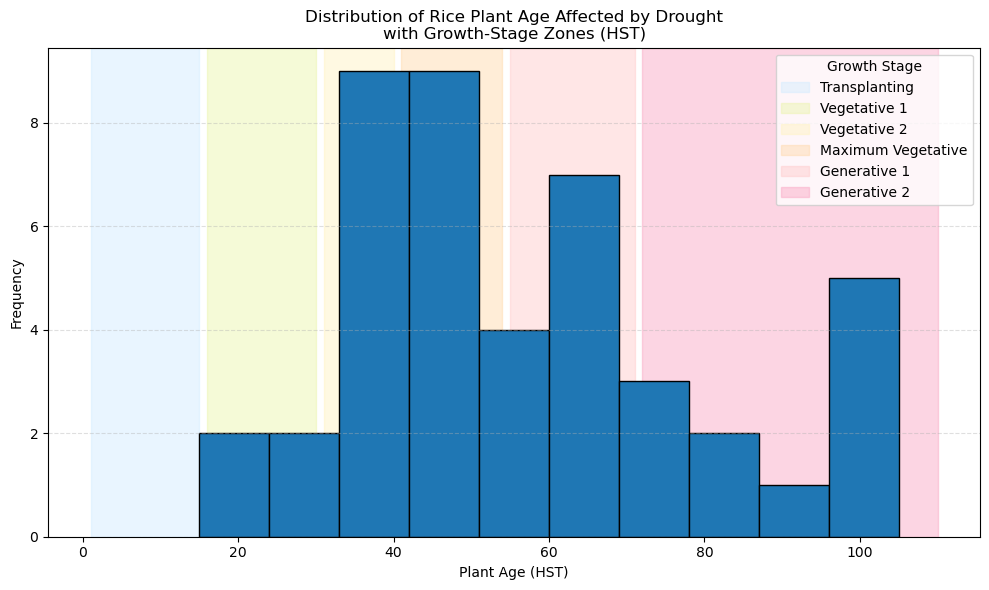

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# HST sample records represented as individual min–max pairs
data_hst = [
    (40,40),(50,70),(65,65),(105,105),(105,105),(50,50),(70,100),(39,45),
    (45,65),(30,55),(15,70),(21,43),(49,58),(40,40),(40,40),(30,45),
    (35,35),(55,60),(55,61),(80,85),(60,65),(50,90)
]

# Convert each min–max pair into individual HST points
hst_points = []
for mn, mx in data_hst:
    hst_points.append(mn)
    hst_points.append(mx)

# Growth stage definitions based on HST (days after transplanting)
fase_bounds = {
    "Transplanting": (1, 15),
    "Vegetative 1": (16, 30),
    "Vegetative 2": (31, 40),
    "Maximum Vegetative": (41, 54),
    "Generative 1": (55, 71),
    "Generative 2": (72, 110),
}

# Color palette for growth-stage shading
fase_colors = {
    "Transplanting": "#d0ebff",
    "Vegetative 1": "#eaf4a8",
    "Vegetative 2": "#fff3bf",
    "Maximum Vegetative": "#ffd8a8",
    "Generative 1": "#ffc9c9",
    "Generative 2": "#faa2c1",
}

plt.figure(figsize=(10, 6))

# Apply background shading for each growth stage
for fase, (xmin, xmax) in fase_bounds.items():
    plt.axvspan(xmin, xmax, color=fase_colors[fase], alpha=0.45, label=fase)

# Histogram of HST occurrences
plt.hist(hst_points, bins=10, edgecolor='black')

# Labels and title
plt.xlabel("Plant Age (HST)")
plt.ylabel("Frequency")
plt.title("Distribution of Rice Plant Age Affected by Drought\nwith Growth-Stage Zones (HST)")

# Legend showing shaded growth stages
handles = [plt.Rectangle((0, 0), 1, 1, color=fase_colors[f], alpha=0.45) for f in fase_bounds]
plt.legend(handles, fase_bounds.keys(), title="Growth Stage", loc="upper right")

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


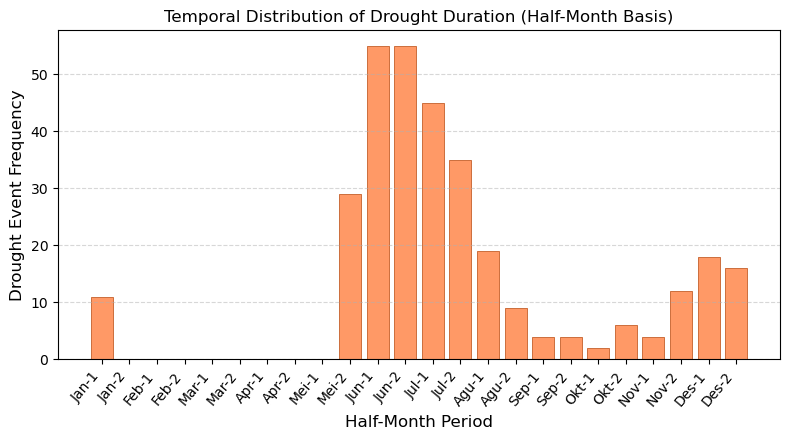

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
drought_samples["period_start"] = pd.to_datetime(drought_samples["period_start"])
drought_samples["period_end"] = pd.to_datetime(drought_samples["period_end"])

# Month names
month_names = ["Jan","Feb","Mar","Apr","Mei","Jun","Jul","Agu","Sep","Okt","Nov","Des"]

def get_halfmonth_label(dt):
    """Return a half-month label such as 'Jun-1' or 'Jun-2'."""
    half = 1 if dt.day <= 15 else 2
    return f"{month_names[dt.month - 1]}-{half}"

# All possible half-month periods
all_halfmonths = [f"{month_names[m-1]}-{h}" for m in range(1, 13) for h in [1, 2]]

# Initialize frequency counter
halfmonth_freq = {hm: 0 for hm in all_halfmonths}

# Count each drought event ONCE for each half-month it intersects
for _, row in drought_samples.iterrows():
    start = row["period_start"]
    end = row["period_end"]

    # Generate all days in the event
    date_range = pd.date_range(start, end, freq="D")

    # Determine unique half-months touched by this event
    unique_hm = set(get_halfmonth_label(dt) for dt in date_range)

    # Count each half-month only once
    for hm in unique_hm:
        halfmonth_freq[hm] += 1

# Create a series for plotting
freq_series = pd.Series(halfmonth_freq)

# Plot
plt.figure(figsize=(8, 4.5))  # Fits A4 portrait width

plt.bar(
    freq_series.index, 
    freq_series.values,
    color="#ff9966",
    edgecolor="#cc6e3c",
    linewidth=0.7
)

plt.title("Temporal Distribution of Drought Duration (Half-Month Basis)", fontsize=12)
plt.xlabel("Half-Month Period", fontsize=12)
plt.ylabel("Drought Event Frequency", fontsize=12)

plt.xticks(rotation=50, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


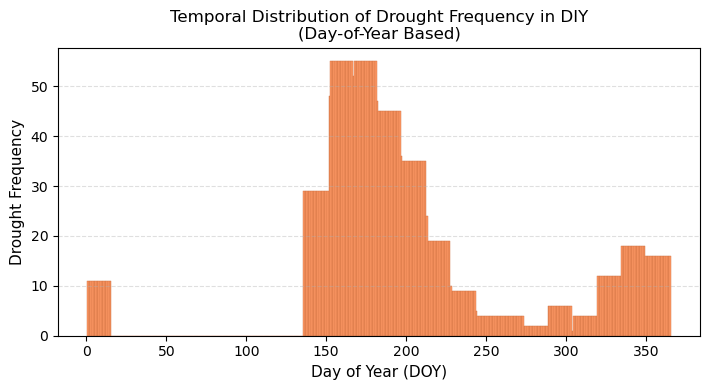

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Pastikan period_start & period_end datetime ---
drought_samples["period_start"] = pd.to_datetime(drought_samples["period_start"])
drought_samples["period_end"] = pd.to_datetime(drought_samples["period_end"]
# --- 2. Fungsi untuk menghasilkan list DOY dalam satu kejadian ---
def expand_doy(row):
    start = row["period_start"].timetuple().tm_yday
    end   = row["period_end"].timetuple().tm_yday
    
    # Jika kekeringan melintasi akhir tahun (jarang tapi bisa)
    if end < start:
        days = list(range(start, 366)) + list(range(1, end+1))
    else:
        days = list(range(start, end+1))
    
    return days

# --- 3. Expand DOY untuk setiap kejadian ---
drought_samples["DOY_range"] = drought_samples.apply(expand_doy, axis=1)

# --- 4. Flatten semua DOY menjadi satu list ---
all_doys = [d for sublist in drought_samples["DOY_range"] for d in sublist]

# --- 5. Hitung frekuensi DOY ---
doy_freq = pd.Series(all_doys).value_counts().sort_index()

# Pastikan DOY 1–365 ada semua
doy_freq = doy_freq.reindex(range(1, 366), fill_value=0)

# --- 6. Plot ala Zhang et al. ---
plt.figure(figsize=(7.2, 4))  # Cocok A4 portrait

plt.bar(
    doy_freq.index,
    doy_freq.values,
    width=1.0,
    color="#ff9966",
    edgecolor="#cc6e3c",
    linewidth=0.3
)

plt.xlabel("Day of Year (DOY)", fontsize=11)
plt.ylabel("Drought Frequency", fontsize=11)
plt.title("Temporal Distribution of Drought Frequency in DIY\n(Day-of-Year Based)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
